<a href="https://colab.research.google.com/github/Cuzime/AE-FITS-Compression/blob/main/Pixel_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
! pip install fpack

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch, MinMaxInterval, SqrtStretch, ImageNormalize, SinhStretch
from sklearn.preprocessing import PowerTransformer
import random
import math
import keras
import os
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from sklearn.preprocessing import StandardScaler
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow_probability as tfp
import time
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorflow Version: 2.15.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# set size of stamps
size = 256
stamps_per_img = 300
step = int(size/2)

def visual_transform_image(image):
    # VISUALIZE THE DATA

    # Scale the image based on its percentiles
    interval = PercentileInterval(99.5)
    vmin, vmax = interval.get_limits(image)
    norm = plt.Normalize(vmin, vmax)

    # Apply an asinh stretch to enhance faint features
    stretch = AsinhStretch()
    scaled_data = stretch(norm(image))

    return scaled_data

In [ ]:
# unzip raw stamps
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-001.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-002.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-003.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-004.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-005.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-006.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-007.zip > /dev/null

In [ ]:
# unzip masks
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask-001.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask-002.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask-003.zip > /dev/null
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask-004.zip > /dev/null

In [ ]:
import os
import shutil

# create a new directory to store the combined raw stamps
combined_mask_dir = os.path.join('/content', 'combined_stamps')
os.makedirs(combined_mask_dir, exist_ok=True)

# copy the masks from the two original directories into the new directory
for mask_file in os.listdir('/content/ZTFrawstamps'):
    shutil.copy2(os.path.join('/content/ZTFrawstamps', mask_file),
                 os.path.join(combined_mask_dir, mask_file))

for mask_file in os.listdir('/content/ZTFrawstamps2'):
    shutil.copy2(os.path.join('/content/ZTFrawstamps2', mask_file),
                 os.path.join(combined_mask_dir, mask_file))

In [ ]:
import os
import shutil

# create a new directory to store the combined masks
combined_mask_dir = os.path.join('/content', 'combined_masks')
os.makedirs(combined_mask_dir, exist_ok=True)

# copy the masks from the two original directories into the new directory
for mask_file in os.listdir('/content/ZTFrawstampsmask'):
    shutil.copy2(os.path.join('/content/ZTFrawstampsmask', mask_file),
                 os.path.join(combined_mask_dir, mask_file))

for mask_file in os.listdir('/content/ZTFrawstampsmask2'):
    shutil.copy2(os.path.join('/content/ZTFrawstampsmask2', mask_file),
                 os.path.join(combined_mask_dir, mask_file))

In [ ]:
folder_path = '/content/combined_stamps'
file_list = os.listdir(folder_path)

full_path_list = []
for file_name in file_list:
  file_path = folder_path + '/' + file_name
  full_path_list.append(file_path)

print(len(full_path_list))

folder_path_masks = '/content/combined_masks'
file_list_masks = os.listdir(folder_path_masks)

full_path_list_masks = []
for file_name in file_list_masks:
  file_path = folder_path + '/' + file_name
  full_path_list_masks.append(file_path)

print(len(full_path_list_masks))

105373
105373


uncompressed file size: 267840 bytes
compressed file size: 8640 bytes
Compression ratio: 31.0


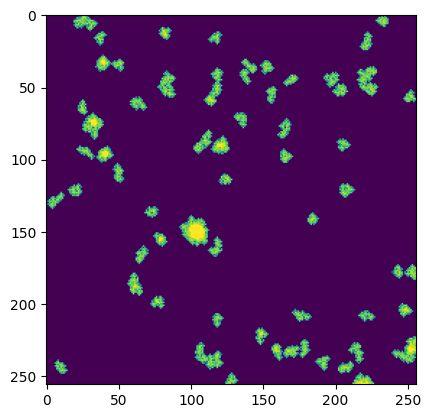

In [ ]:
# test compression
from astropy.io import fits

idx = 3401
file_path = full_path_list[idx]
mask_data = np.load('/content/combined_masks/' + file_path[24:-4] + '_mask.npy')
image_data = np.load(file_path)

image_data = image_data.reshape(256,256).astype('float32')
mask_data = mask_data.reshape(256,256)

plt.imshow(visual_transform_image(image_data)*mask_data)

compression_type = 'HCOMPRESS_1'
hdu = fits.PrimaryHDU(image_data)
hdu.writeto('uncompressed_file.fits', overwrite = True)
compressed_hdu = fits.CompImageHDU(data = image_data, compression_type=compression_type, quantize_level = 2, hcomp_scale=20)

new_hdulist = fits.HDUList([fits.PrimaryHDU(), compressed_hdu])
new_hdulist.writeto('COMP_compressed_file.fits', overwrite = True)

file_path = 'uncompressed_file.fits'
file_size = os.path.getsize(file_path)
print('uncompressed file size:', file_size, 'bytes')

file_path_comp = 'COMP_compressed_file.fits'
file_size_comp = os.path.getsize(file_path_comp)
print('compressed file size:', file_size_comp, 'bytes')

print('Compression ratio:', file_size/file_size_comp)


In [ ]:
!apt-get install libcfitsio-bin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libcfitsio-bin
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 41.7 kB of archives.
After this operation, 167 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcfitsio-bin amd64 4.0.0-1 [41.7 kB]
Fetched 41.7 kB in 1s (76.5 kB/s)
Selecting previously unselected package libcfitsio-bin.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../libcfitsio-bin_4.0.0-1_amd64.deb ...
Unpacking libcfitsio-bin (4.0.0-1) ...
Setting up libcfitsio-bin (4.0.0-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
os.remove('/content/uncompressed_file.fits.fz')

In [ ]:
! fpack -h -q 2 -s 22 uncompressed_file.fits

In [ ]:
file_path_comp = '/content/uncompressed_file.fits.fz'
file_size_comp = os.path.getsize(file_path_comp)
print('compressed file size:', file_size_comp, 'bytes')

print('Compression ratio:', file_size/file_size_comp)


compressed file size: 14400 bytes
Compression ratio: 18.6


15439


Text(0.5, 1.0, 'Histogram of Masked Residuals')

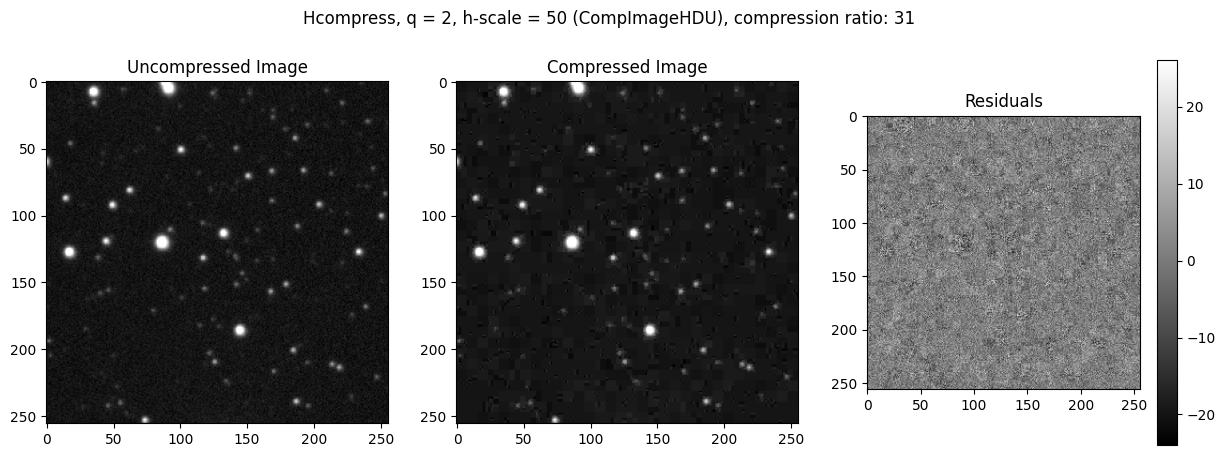

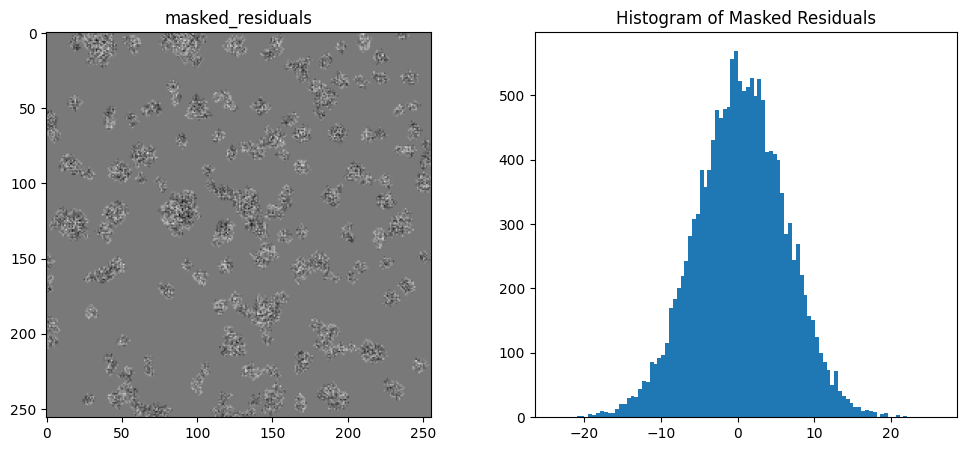

In [ ]:
with fits.open('/content/uncompressed_file.fits.fz') as hdu:
  fpack_data = hdu[1].data

with fits.open('/content/COMP_compressed_file.fits') as hdu:
  COMP_data = hdu[1].data

with fits.open('/content/uncompressed_file.fits') as hdu:
  image_data = hdu[0].data

compressed_data = COMP_data

fig, axs = plt.subplots(1,3, figsize = (15,5))

plt.suptitle('Hcompress, q = 2, h-scale = 50 (CompImageHDU), compression ratio: 31')

axs[0].imshow(visual_transform_image(image_data), cmap = 'gray')
axs[0].set_title('Uncompressed Image')
#plt.colorbar(axs[0].imshow(image_data, cmap = 'gray'), ax = axs[0])

axs[1].imshow(visual_transform_image(compressed_data), cmap = 'gray')
axs[1].set_title('Compressed Image')
#plt.colorbar(axs[1].imshow(compressed_data, cmap = 'gray'), ax = axs[1])

residuals = (compressed_data-image_data)

axs[2].imshow((compressed_data-image_data), cmap = 'gray')
axs[2].set_title('Residuals')
plt.colorbar(axs[2].imshow(residuals, cmap = 'gray'), ax = axs[2])

fig, axs = plt.subplots(1,2, figsize = (12,5))
masked_residuals = residuals*mask_data
axs[0].imshow(masked_residuals, cmap = 'gray')
axs[0].set_title('masked_residuals')

masked_residuals_flat = masked_residuals.flatten()
masked_residuals_flat = masked_residuals_flat[masked_residuals_flat != 0]
print(len(masked_residuals_flat))
#masked_residuals_flat = fpack_data.flatten()[9000:16000]

axs[1].hist(masked_residuals_flat, bins = 100)
axs[1].set_title('Histogram of Masked Residuals')

# Data Generators

1.0063207149505615
(15, 256, 256, 1)
(15, 256, 256, 1)


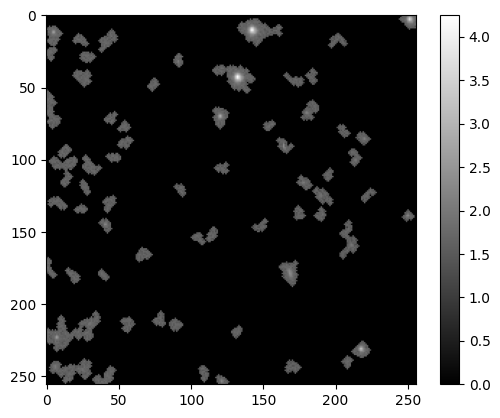

In [ ]:
# raw stamps generator
train_path_list = full_path_list[0:100000]
test_path_list = full_path_list[100000:]

def generate_train_stamps_mask_raw(batch_size):
  while True:
    counter = 0
    stamp_list = []
    mask_list = []
    for file_path in train_path_list:
      if (counter == batch_size):
        counter = 0
        yield (np.array(stamp_list), np.array(mask_list))
        #yield np.array(stamp_list)
        stamp_list = []
        mask_list = []

      image_data = np.load(file_path)
      #image_data = image_data.reshape(1,256,256)
      mask_data = np.load('/content/combined_masks/' + file_path[24:-4] + '_mask.npy')
      mask_data = mask_data.reshape(256,256,1)


      interval = MinMaxInterval()
      vmin, vmax = interval.get_limits(image_data)
      image_data_scaled = np.log10(image_data-vmin+1)

      mask_list.append(mask_data)
      stamp_list.append(image_data_scaled)
      counter += 1

def generate_test_stamps_mask_raw(batch_size):
  while True:
    counter = 0
    stamp_list = []
    mask_list = []
    for file_path in test_path_list:
      if (counter == batch_size):
        counter = 0
        yield (np.array(stamp_list), np.array(mask_list))
        #yield np.array(stamp_list)
        stamp_list = []
        mask_list = []

      image_data = np.load(file_path)
      #image_data = image_data.reshape(1,256,256)
      mask_data = np.load('/content/combined_masks/' + file_path[24:-4] + '_mask.npy')
      mask_data = mask_data.reshape(256,256,1)

      interval = MinMaxInterval()
      vmin, vmax = interval.get_limits(image_data)
      image_data_scaled = np.log10(image_data-vmin+1)

      mask_list.append(mask_data)
      stamp_list.append(image_data_scaled)
      counter += 1


gen = generate_train_stamps_mask_raw(15)

start = time.time()
for i in range(12):
  stamps, masks = next(gen)
  #stamps = next(gen)
end = time.time()
print(end-start)
print(np.shape(stamps))
print(np.shape(masks))

idx = 13
#interval = MinMaxInterval()
#vmin, vmax = interval.get_limits(stamps[idx])
#stamp = np.log10(stamps[idx]-vmin+1)

stamps_masked = np.multiply(stamps, masks)

stamp = stamps_masked[idx]

plt.imshow(stamp.reshape(256,256),cmap = 'gray')
plt.colorbar()


## Focal Frequency Loss

In [ ]:
! pip install tf-focal-frequency-loss

In [ ]:
from tf_focal_frequency_loss import FocalFrequencyLoss as FFL
ffl = FFL(loss_weight=1.0, alpha=1.0)

fake = tf.random.normal((4, 3, 64, 64))  # replace it with the predicted tensor of shape (N, C, H, W)
real = tf.random.normal((4, 3, 64, 64))  # replace it with the target tensor of shape (N, C, H, W)

loss = ffl(fake, real)  # calculate focal frequency loss
print(loss)

tf.Tensor(0.9164129, shape=(), dtype=float32)


# Autoencoder Model

In [ ]:
shape = (size, size)
input_shape = (size, size,1)

# for focal frequency loss, the data shape is (num_batches, channels, height, width)

""" PixelCNN Autoencoder that predicts raw_image - vmin + 1"""

class PCNNae(keras.Model):

    def PCNNae_compile(self,
                    encoder,
                    decoder_mean,
                    decoder_var,
                    scaler_mean,
                    #scaler_var,
                    encoder_optimizer,
                    decoder_mean_optimizer,
                    decoder_var_optimizer,
                    scaler_mean_optimizer,
                    #scaler_var_optimizer,
                    epsilon=1,
                    beta = 100,
                    **kwargs):
        super().compile()
        self.mean_optimizer = decoder_mean_optimizer
        self.var_optimizer = decoder_var_optimizer
        self.scaler_mean_optimizer = scaler_mean_optimizer
        #self.scaler_var_optimizer = scaler_var_optimizer
        self.encoder_optimizer = encoder_optimizer
        self.mle_loss_tracker = keras.metrics.Mean(name="mle_loss")
        #self.kl_loss_tracker = keras.metrics.Mean(name ="kl_loss")
        self.var_loss_tracker = keras.metrics.Mean(name="var_loss")
        self.decoder_loss_tracker = keras.metrics.Mean(name = "decoder_mse")
        self.scaler_loss_tracker = keras.metrics.Mean(name = "scaler_mse")
        self.beta = beta
        self.epsilon = epsilon
        self.decoder_mean = decoder_mean
        self.decoder_var = decoder_var
        self.encoder = encoder
        self.scaler_mean = scaler_mean
        #self.scaler_var = scaler_var

    def train_step(self, data):
        stamps, masks = data
        masks = tf.cast(masks, tf.float32)

        """"FULLY CONV MODEL WITHOUT TUNING"""
        with tf.GradientTape(persistent = True) as tape:
            """forward pass decoder_mean"""
            codes = self.encoder(stamps, training = True)
            norm_predict = self.decoder_mean(codes, training = True)

            """Calculate MSE decoder_mean loss with mask"""
            #decoder_loss = K.mean(tf.math.multiply(K.square(norm_predict - stamps), masks))

            """Calculate FFL decoder_mean loss"""
            norm_predict_ffl = tf.reshape(norm_predict, (-1,1,256,256))
            stamps_ffl = tf.reshape(stamps, (-1,1,256,256))
            decoder_loss = ffl(norm_predict_ffl,stamps_ffl) #+ K.mean(tf.math.multiply(K.square(norm_predict - stamps), masks))

            """forward pass scaler_mean"""
            raw_predict = self.scaler_mean(norm_predict, training = True)

            """Calculate MSE scaler_mean loss with mask"""
            #scaler_loss = K.mean(tf.math.multiply(K.square(raw_predict - tf.math.pow(10.0, stamps)), masks))
            #+ self.beta * K.mean(tf.math.multiply(K.square(tf.experimental.numpy.log10(raw_predict) - stamps), masks))

            """Calculate FFL scaler_mean loss"""
            raw_predict_ffl = tf.reshape(raw_predict, (-1,1,256,256))
            scaler_loss = ffl(raw_predict_ffl, tf.math.pow(10.0,stamps_ffl)) #+ K.mean(tf.math.multiply(K.square(raw_predict - tf.math.pow(10.0, stamps)), masks))

        """apply gradients to decoder_mean and encoder"""
        decoder_mean_grads = tape.gradient(decoder_loss, self.decoder_mean.trainable_weights)
        encoder_grads = tape.gradient(decoder_loss, self.encoder.trainable_weights)
        self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))
        self.mean_optimizer.apply_gradients(zip(decoder_mean_grads, self.decoder_mean.trainable_weights))

        """apply gradients to scaler_mean"""
        scaler_mean_grads = tape.gradient(scaler_loss, self.scaler_mean.trainable_weights)
        self.scaler_mean_optimizer.apply_gradients(zip(scaler_mean_grads, self.scaler_mean.trainable_weights))

        with tf.GradientTape(persistent = True) as tape:
            """forward pass variance"""
            codes = self.encoder(stamps, training = True)
            var_img = self.decoder_var(codes, training = True)
            mean_img = self.decoder_mean(codes, training = False)

            """Calulate MLE decoder_var loss"""
            mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - stamps) / (var_img+self.epsilon)
            mle_loss = K.mean(mle_loss)

            "Variance Loss"
            var_loss = mle_loss

        """apply gradients to decoder_var"""
        var_grads = tape.gradient(var_loss, self.decoder_var.trainable_weights)
        self.var_optimizer.apply_gradients(zip(var_grads, self.decoder_var.trainable_weights))
        # encoder_grads = tape.gradient(var_loss, self.encoder.trainable_weights)
        # self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))

        """update state of trackers"""
        self.mle_loss_tracker.update_state(mle_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        self.var_loss_tracker.update_state(var_loss)
        self.decoder_loss_tracker.update_state(decoder_loss)
        self.scaler_loss_tracker.update_state(scaler_loss)

        return {
            "scaler_loss": self.scaler_loss_tracker.result(),
            "decoder_loss": self.decoder_loss_tracker.result(),
            "var_loss": self.var_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
            #"mle_loss": self.mle_loss_tracker.result(),
        }

    def test_step(self, data):

        stamps, masks = data
        masks = tf.cast(masks, tf.float32)

        """forward pass decoder_mean"""
        codes = self.encoder(stamps, training = True)
        norm_predict = self.decoder_mean(codes, training = True)

        """Calculate MSE decoder_mean loss with mask"""
        #decoder_loss = K.mean(tf.math.multiply(K.square(norm_predict - stamps), masks))

        """Calculate FFL decoder_mean loss"""
        norm_predict_ffl = tf.reshape(norm_predict, (-1,1,256,256))
        stamps_ffl = tf.reshape(stamps, (-1,1,256,256))
        decoder_loss = ffl(norm_predict_ffl,stamps_ffl) #+ K.mean(tf.math.multiply(K.square(norm_predict - stamps), masks))

        """forward pass scaler_mean"""
        raw_predict = self.scaler_mean(norm_predict, training = True)

        """Calculate MSE scaler_mean loss with mask"""
        #scaler_loss = K.mean(tf.math.multiply(K.square(raw_predict - tf.math.pow(10.0, stamps)), masks))
        #+ self.beta * K.mean(tf.math.multiply(K.square(tf.experimental.numpy.log10(raw_predict) - stamps), masks))

        """Calculate FFL scaler_mean loss"""
        raw_predict_ffl = tf.reshape(raw_predict, (-1,1,256,256))
        scaler_loss = ffl(raw_predict_ffl, tf.math.pow(10.0,stamps_ffl)) #+ K.mean(tf.math.multiply(K.square(raw_predict - tf.math.pow(10.0, stamps)), masks))

        var_img = self.decoder_var(codes, training = True)
        mean_img = self.decoder_mean(codes, training = False)

        """Calulate MLE decoder_var loss"""
        mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - stamps) / (var_img+self.epsilon)
        mle_loss = K.mean(mle_loss)

        "Variance Loss"
        var_loss = mle_loss

        self.decoder_loss_tracker.reset_states()
        self.scaler_loss_tracker.reset_states()
        self.mle_loss_tracker.reset_states()
        self.var_loss_tracker.reset_states()
        #self.kl_loss_tracker.reset_states()
        #self.kl_loss_tracker.update_state(kl_loss)
        self.mle_loss_tracker.update_state(mle_loss)
        self.var_loss_tracker.update_state(var_loss)
        self.decoder_loss_tracker.update_state(decoder_loss)
        self.scaler_loss_tracker.update_state(scaler_loss)

        return {
            "scaler_loss": self.scaler_loss_tracker.result(),
            "decoder_loss": self.decoder_loss_tracker.result(),
            "var_loss": self.var_loss_tracker.result()
        }

    """this is only for tuning the compression (not complete)"""
    def custom_predict(self, data, comp_param):
        x = data
        # forward pass
        codes = self.encoder(x, training = False)
        """"masking process"""
        codes_shape = K.int_shape(codes)[1:]
        comp_param = comp_param
        #mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
        #codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)

        return mean_img, var_img

In [ ]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [ ]:
"""set hyperparameters"""
epochs = 300
batch_size = 64
steps_per_epoch = 500
enc_filters = [64,64,4]
dec_filters = [64,64,128]
learning_rate = 0.001
noise_std = 0.1
epsilon = noise_std**2
beta = 0

keras.backend.clear_session()

"""AUTOENCODER ARCHITECTURE"""

with tf.device(device_name = '/device:GPU:0'):

  input = keras.Input(shape = input_shape)
  enc_layer = input

  # encoder
  enc_layer = PixelConvLayer(mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same")(enc_layer)
  enc_layer = keras.layers.BatchNormalization()(enc_layer)

  for filters in enc_filters:
    enc_layer = keras.layers.Conv2D(filters, (3,3), activation = 'relu', padding = 'same')(enc_layer)
    enc_layer = keras.layers.BatchNormalization()(enc_layer)
    enc_layer = keras.layers.MaxPooling2D((2,2), padding = 'same')(enc_layer)

  # decoder mean
  mean_layer = enc_layer

  for filters in dec_filters:
      mean_layer = keras.layers.Conv2DTranspose(filters, (3,3), activation = 'relu', padding = 'same')(mean_layer)
      mean_layer = keras.layers.BatchNormalization()(mean_layer)
      mean_layer = keras.layers.UpSampling2D((2,2))(mean_layer)

  mean_layer = ResidualBlock(filters=128)(mean_layer)
  mean_layer = ResidualBlock(filters=128)(mean_layer)

  mean_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(mean_layer)
  mean_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(mean_layer)
  mean_predict = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, activation="linear", padding="same")(mean_layer)

  # decoder var
  var_layer = enc_layer

  for filters in dec_filters:
    var_layer = keras.layers.Conv2DTranspose(filters, (3,3), activation = 'relu', padding = 'same')(var_layer)
    var_layer = keras.layers.BatchNormalization()(var_layer)
    var_layer = keras.layers.UpSampling2D((2,2))(var_layer)

  var_layer = ResidualBlock(filters=128)(var_layer)
  var_layer = ResidualBlock(filters=128)(var_layer)

  var_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="valid")(var_layer)
  var_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="valid")(var_layer)
  var_predict = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, activation="relu", padding="valid")(var_layer)

  decoder_mean = keras.Model(enc_layer, mean_predict, name = 'decoder_mean')
  decoder_var = keras.Model(enc_layer, var_predict, name = 'decoder_var')
  encoder = keras.Model(input, enc_layer, name = 'encoder')

  # scaler mean
  scaler_mean_layer = mean_predict
  scaler_mean_layer = ResidualBlock(filters = 128)(scaler_mean_layer)
  #scaler_mean_layer = ResidualBlock(filters = 128)(scaler_mean_layer)
  scaler_mean_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(scaler_mean_layer)
  #scaler_mean_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(scaler_mean_layer)
  scaler_mean_predict = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, activation="linear", padding="same")(scaler_mean_layer)

  scaler_mean = keras.Model(mean_predict, scaler_mean_predict, name = 'scaler_mean')

  autoencoder_C = PCNNae(input, [scaler_mean_predict, var_predict])
  decoder_mean_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  decoder_var_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  scaler_mean_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

  autoencoder_C.PCNNae_compile(decoder_mean = decoder_mean, decoder_var = decoder_var, encoder = encoder,
                                decoder_mean_optimizer=decoder_mean_optimizer, decoder_var_optimizer = decoder_var_optimizer,
                                encoder_optimizer = encoder_optimizer,
                                scaler_mean = scaler_mean, scaler_mean_optimizer = scaler_mean_optimizer,
                                epsilon = epsilon,
                                beta = beta
                                )

  encoder.summary()
  decoder_mean.summary()
  decoder_var.summary()
  scaler_mean.summary()

  #autoencoder_C.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 pixel_conv_layer (PixelCon  (None, 256, 256, 128)     6400      
 vLayer)                                                         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      73792     
                                                                 
 batch_normalization_1 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                                                
                                                           

In [ ]:
# WANDB INIT

# start run, tracking hyperparameters
run = wandb.init(mode = 'online',
    #set project
    project = "PixelCNN_mask",

    config = {
        "epochs": epochs,
        "steps_per_epoch": steps_per_epoch,
        "batch_size": batch_size,
        "enc_filters": enc_filters,
        #"encoder_dense": encoding_dense,
        #"decoder_dense" : decoding_dense,
        "dec_filters": dec_filters,
        "input_shape": input_shape,
        "shape": shape,
        "noise_std": noise_std,
        "learning_rate": learning_rate,
        "epsilon": epsilon,
        "beta": beta,
        #"percentile_interval": percentile_interval,
        #"a": a,
    }
)


# FIT

lr = 0.0000001
lr = 0.0001

def scheduler(epoch, lr):
  if epoch < 30:
    return 0.001
  elif epoch < 60:
    return 0.001
  elif epoch < 100:
    return 0.001
  else:
    return 0.001

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

with tf.device(device_name = '/device:GPU:0'):
    autoencoder_C.fit(x = generate_train_stamps_mask_raw(16),
                    epochs = 60,
                      steps_per_epoch = steps_per_epoch,
                      batch_size = batch_size,
                      validation_data=generate_test_stamps_mask_raw(20),
                      validation_steps = 120,
                      shuffle = True,
                    callbacks = [lr_scheduler, WandbMetricsLogger(log_freq=5),
                    WandbModelCheckpoint("/models/gae_model/", save_weights_only = True, monitor = 'val_loss')])

wandb: Currently logged in as: agoh (cuzime). Use `wandb login --relogin` to force relogin


Epoch 1/60
500/500 [==============================] - ETA: 0s - scaler_loss: 276558.6065 - decoder_loss: 0.0016 - var_loss: -3.0293

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 276510.1845 - decoder_loss: 0.0016 - var_loss: -3.0293 - val_scaler_loss: 26176.6250 - val_decoder_loss: 0.0011 - val_var_loss: -3.1323 - lr: 0.0010
Epoch 2/60
500/500 [==============================] - ETA: 0s - scaler_loss: 168066.4054 - decoder_loss: 0.0019 - var_loss: -2.9649

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 167972.8045 - decoder_loss: 0.0019 - var_loss: -2.9649 - val_scaler_loss: 182320.7344 - val_decoder_loss: 0.0016 - val_var_loss: -2.9244 - lr: 0.0010
Epoch 3/60
500/500 [==============================] - ETA: 0s - scaler_loss: 106549.7151 - decoder_loss: 0.0016 - var_loss: -2.9963

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 106659.7093 - decoder_loss: 0.0016 - var_loss: -2.9963 - val_scaler_loss: 32350.9570 - val_decoder_loss: 0.0012 - val_var_loss: -3.5131 - lr: 0.0010
Epoch 4/60
500/500 [==============================] - ETA: 0s - scaler_loss: 262457.7593 - decoder_loss: 0.0017 - var_loss: -2.9906

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 262380.6370 - decoder_loss: 0.0017 - var_loss: -2.9906 - val_scaler_loss: 26734.1406 - val_decoder_loss: 0.0017 - val_var_loss: -3.0697 - lr: 0.0010
Epoch 5/60
500/500 [==============================] - ETA: 0s - scaler_loss: 124472.5399 - decoder_loss: 0.0018 - var_loss: -3.0049

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 124425.2124 - decoder_loss: 0.0018 - var_loss: -3.0049 - val_scaler_loss: 26655.9121 - val_decoder_loss: 0.0010 - val_var_loss: -3.3512 - lr: 0.0010
Epoch 6/60
500/500 [==============================] - ETA: 0s - scaler_loss: 81443.0707 - decoder_loss: 0.0017 - var_loss: -3.0231

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 81429.4498 - decoder_loss: 0.0017 - var_loss: -3.0231 - val_scaler_loss: 93082.3906 - val_decoder_loss: 0.0015 - val_var_loss: -3.4212 - lr: 0.0010
Epoch 7/60
500/500 [==============================] - ETA: 0s - scaler_loss: 132877.3141 - decoder_loss: 0.0020 - var_loss: -2.9741

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 132836.1412 - decoder_loss: 0.0020 - var_loss: -2.9741 - val_scaler_loss: 161539.9219 - val_decoder_loss: 0.0073 - val_var_loss: -1.5269 - lr: 0.0010
Epoch 8/60
500/500 [==============================] - ETA: 0s - scaler_loss: 59933.0402 - decoder_loss: 0.0020 - var_loss: -3.0001

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 59960.2077 - decoder_loss: 0.0020 - var_loss: -3.0001 - val_scaler_loss: 109317.9375 - val_decoder_loss: 0.0021 - val_var_loss: -2.8977 - lr: 0.0010
Epoch 9/60
500/500 [==============================] - ETA: 0s - scaler_loss: 101376.1943 - decoder_loss: 0.0017 - var_loss: -2.9712

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 101418.0652 - decoder_loss: 0.0017 - var_loss: -2.9712 - val_scaler_loss: 23039.0469 - val_decoder_loss: 0.0039 - val_var_loss: -2.2241 - lr: 0.0010
Epoch 10/60
500/500 [==============================] - ETA: 0s - scaler_loss: 62133.2323 - decoder_loss: 0.0016 - var_loss: -2.9834

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 62133.1737 - decoder_loss: 0.0016 - var_loss: -2.9834 - val_scaler_loss: 16298.9629 - val_decoder_loss: 0.0014 - val_var_loss: -2.8451 - lr: 0.0010
Epoch 11/60
500/500 [==============================] - ETA: 0s - scaler_loss: 89866.5468 - decoder_loss: 0.0016 - var_loss: -3.0123

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 90020.1904 - decoder_loss: 0.0016 - var_loss: -3.0123 - val_scaler_loss: 160787.4688 - val_decoder_loss: 0.0012 - val_var_loss: -3.4628 - lr: 0.0010
Epoch 12/60
500/500 [==============================] - ETA: 0s - scaler_loss: 357288.1738 - decoder_loss: 0.0016 - var_loss: -2.9975

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 558ms/step - scaler_loss: 357328.8331 - decoder_loss: 0.0016 - var_loss: -2.9975 - val_scaler_loss: 656904.3750 - val_decoder_loss: 0.0017 - val_var_loss: -2.8012 - lr: 0.0010
Epoch 13/60
500/500 [==============================] - ETA: 0s - scaler_loss: 528225.9002 - decoder_loss: 0.0019 - var_loss: -3.0200

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 558ms/step - scaler_loss: 528187.1595 - decoder_loss: 0.0019 - var_loss: -3.0200 - val_scaler_loss: 30636.0977 - val_decoder_loss: 9.5611e-04 - val_var_loss: -3.5286 - lr: 0.0010
Epoch 14/60
500/500 [==============================] - ETA: 0s - scaler_loss: 156221.7916 - decoder_loss: 0.0016 - var_loss: -3.0146

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 156173.1608 - decoder_loss: 0.0016 - var_loss: -3.0146 - val_scaler_loss: 1266702.7500 - val_decoder_loss: 0.0034 - val_var_loss: -3.3335 - lr: 0.0010
Epoch 15/60
500/500 [==============================] - ETA: 0s - scaler_loss: 71825.4972 - decoder_loss: 0.0017 - var_loss: -2.9780

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 71869.7169 - decoder_loss: 0.0017 - var_loss: -2.9780 - val_scaler_loss: 10790.3369 - val_decoder_loss: 0.0010 - val_var_loss: -3.2311 - lr: 0.0010
Epoch 16/60
500/500 [==============================] - ETA: 0s - scaler_loss: 89259.1581 - decoder_loss: 0.0019 - var_loss: -2.9952

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 89250.9242 - decoder_loss: 0.0019 - var_loss: -2.9952 - val_scaler_loss: 52003.1016 - val_decoder_loss: 0.0021 - val_var_loss: -2.9054 - lr: 0.0010
Epoch 17/60
500/500 [==============================] - ETA: 0s - scaler_loss: 95535.5223 - decoder_loss: 0.0017 - var_loss: -3.0036

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 95551.5955 - decoder_loss: 0.0017 - var_loss: -3.0036 - val_scaler_loss: 12952.1396 - val_decoder_loss: 9.9817e-04 - val_var_loss: -3.5403 - lr: 0.0010
Epoch 18/60
500/500 [==============================] - ETA: 0s - scaler_loss: 137749.9848 - decoder_loss: 0.0016 - var_loss: -3.0198

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 137939.2312 - decoder_loss: 0.0016 - var_loss: -3.0198 - val_scaler_loss: 98594.1484 - val_decoder_loss: 0.0011 - val_var_loss: -3.1914 - lr: 0.0010
Epoch 19/60
500/500 [==============================] - ETA: 0s - scaler_loss: 144957.0788 - decoder_loss: 0.0017 - var_loss: -2.9843

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 144881.4315 - decoder_loss: 0.0017 - var_loss: -2.9843 - val_scaler_loss: 29947.8340 - val_decoder_loss: 0.0015 - val_var_loss: -2.5338 - lr: 0.0010
Epoch 20/60
500/500 [==============================] - ETA: 0s - scaler_loss: 71925.2486 - decoder_loss: 0.0016 - var_loss: -2.9949

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 71907.4313 - decoder_loss: 0.0016 - var_loss: -2.9949 - val_scaler_loss: 65678.3906 - val_decoder_loss: 0.0012 - val_var_loss: -3.0414 - lr: 0.0010
Epoch 21/60
500/500 [==============================] - ETA: 0s - scaler_loss: 67749.4543 - decoder_loss: 0.0016 - var_loss: -2.9939

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 67763.2686 - decoder_loss: 0.0016 - var_loss: -2.9939 - val_scaler_loss: 99466.6797 - val_decoder_loss: 0.0012 - val_var_loss: -3.2846 - lr: 0.0010
Epoch 22/60
500/500 [==============================] - ETA: 0s - scaler_loss: 80228.2570 - decoder_loss: 0.0017 - var_loss: -2.9896

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 80215.6994 - decoder_loss: 0.0017 - var_loss: -2.9896 - val_scaler_loss: 25666.6016 - val_decoder_loss: 0.0014 - val_var_loss: -3.1233 - lr: 0.0010
Epoch 23/60
500/500 [==============================] - ETA: 0s - scaler_loss: 52459.5657 - decoder_loss: 0.0016 - var_loss: -2.9725

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 52471.9344 - decoder_loss: 0.0016 - var_loss: -2.9725 - val_scaler_loss: 59792.0508 - val_decoder_loss: 0.0011 - val_var_loss: -2.7030 - lr: 0.0010
Epoch 24/60
500/500 [==============================] - ETA: 0s - scaler_loss: 97491.3180 - decoder_loss: 0.0015 - var_loss: -3.0093

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 97737.9770 - decoder_loss: 0.0015 - var_loss: -3.0093 - val_scaler_loss: 102792.5156 - val_decoder_loss: 0.0041 - val_var_loss: -2.8110 - lr: 0.0010
Epoch 25/60
500/500 [==============================] - ETA: 0s - scaler_loss: 301931.4173 - decoder_loss: 0.0018 - var_loss: -3.0404

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 301986.2625 - decoder_loss: 0.0018 - var_loss: -3.0404 - val_scaler_loss: 32397.2695 - val_decoder_loss: 0.0014 - val_var_loss: -3.0220 - lr: 0.0010
Epoch 26/60
500/500 [==============================] - ETA: 0s - scaler_loss: 82878.7891 - decoder_loss: 0.0016 - var_loss: -3.0385

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 281s 562ms/step - scaler_loss: 82858.5981 - decoder_loss: 0.0016 - var_loss: -3.0385 - val_scaler_loss: 106781.9141 - val_decoder_loss: 0.0014 - val_var_loss: -3.2622 - lr: 0.0010
Epoch 27/60
500/500 [==============================] - ETA: 0s - scaler_loss: 72151.2837 - decoder_loss: 0.0016 - var_loss: -2.9848

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 72141.6673 - decoder_loss: 0.0016 - var_loss: -2.9848 - val_scaler_loss: 25296.1035 - val_decoder_loss: 0.0016 - val_var_loss: -3.3748 - lr: 0.0010
Epoch 28/60
500/500 [==============================] - ETA: 0s - scaler_loss: 99045.9851 - decoder_loss: 0.0015 - var_loss: -3.0149

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 99104.6337 - decoder_loss: 0.0015 - var_loss: -3.0149 - val_scaler_loss: 36326.8047 - val_decoder_loss: 0.0012 - val_var_loss: -2.9148 - lr: 0.0010
Epoch 29/60
500/500 [==============================] - ETA: 0s - scaler_loss: 98280.8318 - decoder_loss: 0.0016 - var_loss: -2.9982

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 98233.4619 - decoder_loss: 0.0016 - var_loss: -2.9982 - val_scaler_loss: 24532.8867 - val_decoder_loss: 0.0012 - val_var_loss: -3.0975 - lr: 0.0010
Epoch 30/60
500/500 [==============================] - ETA: 0s - scaler_loss: 107163.2807 - decoder_loss: 0.0015 - var_loss: -3.0090

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 107118.1834 - decoder_loss: 0.0015 - var_loss: -3.0090 - val_scaler_loss: 70880.8047 - val_decoder_loss: 0.0037 - val_var_loss: -2.7609 - lr: 0.0010
Epoch 31/60
500/500 [==============================] - ETA: 0s - scaler_loss: 70869.0351 - decoder_loss: 0.0015 - var_loss: -3.0320

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 70856.5323 - decoder_loss: 0.0015 - var_loss: -3.0320 - val_scaler_loss: 25601.3164 - val_decoder_loss: 0.0014 - val_var_loss: -3.4177 - lr: 0.0010
Epoch 32/60
500/500 [==============================] - ETA: 0s - scaler_loss: 304585.5041 - decoder_loss: 0.0016 - var_loss: -2.9809

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 282s 563ms/step - scaler_loss: 304537.3563 - decoder_loss: 0.0016 - var_loss: -2.9809 - val_scaler_loss: 23105.8574 - val_decoder_loss: 0.0016 - val_var_loss: -3.0863 - lr: 0.0010
Epoch 33/60
500/500 [==============================] - ETA: 0s - scaler_loss: 137725.4422 - decoder_loss: 0.0016 - var_loss: -3.0312

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 281s 562ms/step - scaler_loss: 137681.3818 - decoder_loss: 0.0016 - var_loss: -3.0312 - val_scaler_loss: 32909.6328 - val_decoder_loss: 0.0013 - val_var_loss: -2.9069 - lr: 0.0010
Epoch 34/60
500/500 [==============================] - ETA: 0s - scaler_loss: 62312.1212 - decoder_loss: 0.0016 - var_loss: -2.9872

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 281s 561ms/step - scaler_loss: 62339.5123 - decoder_loss: 0.0016 - var_loss: -2.9872 - val_scaler_loss: 80675.4922 - val_decoder_loss: 0.0018 - val_var_loss: -2.8252 - lr: 0.0010
Epoch 35/60
500/500 [==============================] - ETA: 0s - scaler_loss: 54603.1814 - decoder_loss: 0.0016 - var_loss: -2.9949

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 54597.1946 - decoder_loss: 0.0016 - var_loss: -2.9949 - val_scaler_loss: 39944.3125 - val_decoder_loss: 0.0011 - val_var_loss: -2.6965 - lr: 0.0010
Epoch 36/60
500/500 [==============================] - ETA: 0s - scaler_loss: 66383.6282 - decoder_loss: 0.0015 - var_loss: -3.0089

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 66373.1219 - decoder_loss: 0.0015 - var_loss: -3.0089 - val_scaler_loss: 43580.5547 - val_decoder_loss: 0.0039 - val_var_loss: -2.1956 - lr: 0.0010
Epoch 37/60
500/500 [==============================] - ETA: 0s - scaler_loss: 186341.4680 - decoder_loss: 0.0017 - var_loss: -3.0222

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 186613.1386 - decoder_loss: 0.0017 - var_loss: -3.0222 - val_scaler_loss: 42038.0547 - val_decoder_loss: 7.5822e-04 - val_var_loss: -3.6191 - lr: 0.0010
Epoch 38/60
500/500 [==============================] - ETA: 0s - scaler_loss: 475736.0115 - decoder_loss: 0.0015 - var_loss: -3.0388

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 475815.5156 - decoder_loss: 0.0015 - var_loss: -3.0388 - val_scaler_loss: 184489.9219 - val_decoder_loss: 0.0014 - val_var_loss: -2.5848 - lr: 0.0010
Epoch 39/60
500/500 [==============================] - ETA: 0s - scaler_loss: 249863.9772 - decoder_loss: 0.0015 - var_loss: -3.0153

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 249875.0282 - decoder_loss: 0.0015 - var_loss: -3.0153 - val_scaler_loss: 27374.5840 - val_decoder_loss: 0.0013 - val_var_loss: -2.4068 - lr: 0.0010
Epoch 40/60
500/500 [==============================] - ETA: 0s - scaler_loss: 82877.9120 - decoder_loss: 0.0018 - var_loss: -2.9801

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 82873.4662 - decoder_loss: 0.0018 - var_loss: -2.9801 - val_scaler_loss: 120977.7109 - val_decoder_loss: 0.0018 - val_var_loss: -3.0674 - lr: 0.0010
Epoch 41/60
500/500 [==============================] - ETA: 0s - scaler_loss: 78580.8347 - decoder_loss: 0.0015 - var_loss: -3.0197

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 78574.3702 - decoder_loss: 0.0015 - var_loss: -3.0197 - val_scaler_loss: 43341.1016 - val_decoder_loss: 0.0013 - val_var_loss: -3.1302 - lr: 0.0010
Epoch 42/60
500/500 [==============================] - ETA: 0s - scaler_loss: 74011.6147 - decoder_loss: 0.0016 - var_loss: -3.0386

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 74008.7196 - decoder_loss: 0.0016 - var_loss: -3.0386 - val_scaler_loss: 20893.3262 - val_decoder_loss: 0.0011 - val_var_loss: -2.9809 - lr: 0.0010
Epoch 43/60
500/500 [==============================] - ETA: 0s - scaler_loss: 59305.9367 - decoder_loss: 0.0015 - var_loss: -3.0562

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 59313.5272 - decoder_loss: 0.0015 - var_loss: -3.0562 - val_scaler_loss: 11864.3750 - val_decoder_loss: 0.0015 - val_var_loss: -3.0731 - lr: 0.0010
Epoch 44/60
500/500 [==============================] - ETA: 0s - scaler_loss: 100310.2962 - decoder_loss: 0.0015 - var_loss: -2.9869

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 100479.0148 - decoder_loss: 0.0015 - var_loss: -2.9869 - val_scaler_loss: 79264.3281 - val_decoder_loss: 0.0011 - val_var_loss: -3.5357 - lr: 0.0010
Epoch 45/60
500/500 [==============================] - ETA: 0s - scaler_loss: 207800.1785 - decoder_loss: 0.0015 - var_loss: -3.0079

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 207727.2155 - decoder_loss: 0.0015 - var_loss: -3.0079 - val_scaler_loss: 15152.1016 - val_decoder_loss: 0.0012 - val_var_loss: -2.6778 - lr: 0.0010
Epoch 46/60
500/500 [==============================] - ETA: 0s - scaler_loss: 65698.5526 - decoder_loss: 0.0015 - var_loss: -3.0045

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 65697.5626 - decoder_loss: 0.0015 - var_loss: -3.0045 - val_scaler_loss: 144603.7344 - val_decoder_loss: 0.0011 - val_var_loss: -2.9215 - lr: 0.0010
Epoch 47/60
500/500 [==============================] - ETA: 0s - scaler_loss: 60920.3096 - decoder_loss: 0.0016 - var_loss: -3.0312

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 60913.5667 - decoder_loss: 0.0016 - var_loss: -3.0312 - val_scaler_loss: 15447.4219 - val_decoder_loss: 0.0011 - val_var_loss: -3.2547 - lr: 0.0010
Epoch 48/60
500/500 [==============================] - ETA: 0s - scaler_loss: 45941.7257 - decoder_loss: 0.0014 - var_loss: -2.9767

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 45949.8441 - decoder_loss: 0.0014 - var_loss: -2.9767 - val_scaler_loss: 20933.7051 - val_decoder_loss: 0.0025 - val_var_loss: -2.9584 - lr: 0.0010
Epoch 49/60
500/500 [==============================] - ETA: 0s - scaler_loss: 50716.3128 - decoder_loss: 0.0014 - var_loss: -3.0154

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 50724.6993 - decoder_loss: 0.0014 - var_loss: -3.0154 - val_scaler_loss: 42497.3438 - val_decoder_loss: 0.0012 - val_var_loss: -2.6567 - lr: 0.0010
Epoch 50/60
500/500 [==============================] - ETA: 0s - scaler_loss: 196346.9915 - decoder_loss: 0.0017 - var_loss: -3.0397

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 196379.0880 - decoder_loss: 0.0017 - var_loss: -3.0397 - val_scaler_loss: 356612.5938 - val_decoder_loss: 0.0049 - val_var_loss: -3.0935 - lr: 0.0010
Epoch 51/60
500/500 [==============================] - ETA: 0s - scaler_loss: 321340.1281 - decoder_loss: 0.0016 - var_loss: -3.0386

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 321074.0647 - decoder_loss: 0.0016 - var_loss: -3.0386 - val_scaler_loss: 344974.3750 - val_decoder_loss: 0.0014 - val_var_loss: -3.1302 - lr: 0.0010
Epoch 52/60
500/500 [==============================] - ETA: 0s - scaler_loss: 114807.0673 - decoder_loss: 0.0016 - var_loss: -3.0006

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 114825.1102 - decoder_loss: 0.0016 - var_loss: -3.0006 - val_scaler_loss: 10735.6602 - val_decoder_loss: 0.0025 - val_var_loss: -3.4796 - lr: 0.0010
Epoch 53/60
500/500 [==============================] - ETA: 0s - scaler_loss: 91789.4986 - decoder_loss: 0.0014 - var_loss: -3.0256

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 91792.5577 - decoder_loss: 0.0014 - var_loss: -3.0256 - val_scaler_loss: 76183.1484 - val_decoder_loss: 0.0011 - val_var_loss: -2.9952 - lr: 0.0010
Epoch 54/60
500/500 [==============================] - ETA: 0s - scaler_loss: 44495.9091 - decoder_loss: 0.0015 - var_loss: -3.0253

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 44509.2984 - decoder_loss: 0.0015 - var_loss: -3.0253 - val_scaler_loss: 48675.3672 - val_decoder_loss: 0.0013 - val_var_loss: -2.6026 - lr: 0.0010
Epoch 55/60
500/500 [==============================] - ETA: 0s - scaler_loss: 66906.0505 - decoder_loss: 0.0016 - var_loss: -3.0215

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 66976.6354 - decoder_loss: 0.0016 - var_loss: -3.0215 - val_scaler_loss: 63774.7109 - val_decoder_loss: 0.0017 - val_var_loss: -3.2402 - lr: 0.0010
Epoch 56/60
500/500 [==============================] - ETA: 0s - scaler_loss: 170475.7183 - decoder_loss: 0.0015 - var_loss: -3.0401

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 559ms/step - scaler_loss: 170362.7409 - decoder_loss: 0.0015 - var_loss: -3.0401 - val_scaler_loss: 318974.9062 - val_decoder_loss: 0.0020 - val_var_loss: -3.0874 - lr: 0.0010
Epoch 57/60
500/500 [==============================] - ETA: 0s - scaler_loss: 66864.7456 - decoder_loss: 0.0015 - var_loss: -2.9938

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 66856.7075 - decoder_loss: 0.0015 - var_loss: -2.9938 - val_scaler_loss: 11221.9297 - val_decoder_loss: 0.0011 - val_var_loss: -3.2340 - lr: 0.0010
Epoch 58/60
500/500 [==============================] - ETA: 0s - scaler_loss: 41322.5961 - decoder_loss: 0.0016 - var_loss: -3.0351

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 41338.1228 - decoder_loss: 0.0016 - var_loss: -3.0351 - val_scaler_loss: 13343.5000 - val_decoder_loss: 0.0012 - val_var_loss: -2.6322 - lr: 0.0010
Epoch 59/60
500/500 [==============================] - ETA: 0s - scaler_loss: 55667.6423 - decoder_loss: 0.0016 - var_loss: -2.9959

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 280s 560ms/step - scaler_loss: 55676.8958 - decoder_loss: 0.0016 - var_loss: -2.9959 - val_scaler_loss: 43166.7109 - val_decoder_loss: 0.0012 - val_var_loss: -3.4149 - lr: 0.0010
Epoch 60/60
500/500 [==============================] - ETA: 0s - scaler_loss: 48367.7494 - decoder_loss: 0.0015 - var_loss: -3.0100

wandb: Adding directory to artifact (/models/gae_model)... Done. 0.0s


500/500 [==============================] - 279s 559ms/step - scaler_loss: 48363.7419 - decoder_loss: 0.0015 - var_loss: -3.0100 - val_scaler_loss: 20716.0176 - val_decoder_loss: 0.0017 - val_var_loss: -3.4242 - lr: 0.0010


In [ ]:
wandb.finish()

batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/decoder_loss,▃▇▄▅█▅▄▃▄▆▇▄▄▂▄▂▅▃▂▃▂▂▂▂▄▂▄▂▂▂▂▁▂▄▃▁▄▂▂▃
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/scaler_loss,▄▂▄▂▂▁▁▃█▁▂▂▂▁▂▂▄▂▂▂▁▄▁▁▄█▂▂▁▃▂▁▁▃▂▁▁▁▁▁
batch/var_loss,▅▇▇▄▇▆▆▆▆█▆▇▇▆▆▁▆▇▆▆▅▇▇▅▆▅▇▆▅▆▅▆▅▅▆▅▆▆▅▅
epoch/decoder_loss,▃█▄▄▆▅▃▃▆▄▇▅▄▂▅▃▃▄▂▃▂▂▅▂▃▃▄▂▂▃▂▃▂▅▃▁▃▂▂▂
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/scaler_loss,▄▂▄▂▂▁▁▃█▂▂▂▂▁▁▁▅▁▂▁▁▄▁▁▅█▂▁▁▃▁▁▁▃▂▂▂▂▁▁
epoch/val_decoder_loss,▁▂▂▁█▂▂▁▁▄▂▁▂▂▂▁▂▂▁▁▂▂▂▁▁▂▂▂▂▁▁▁▁▅▃▁▂▂▁▂


1/1 [==============================] - 0s 20ms/step
Compression ratio: 23.25


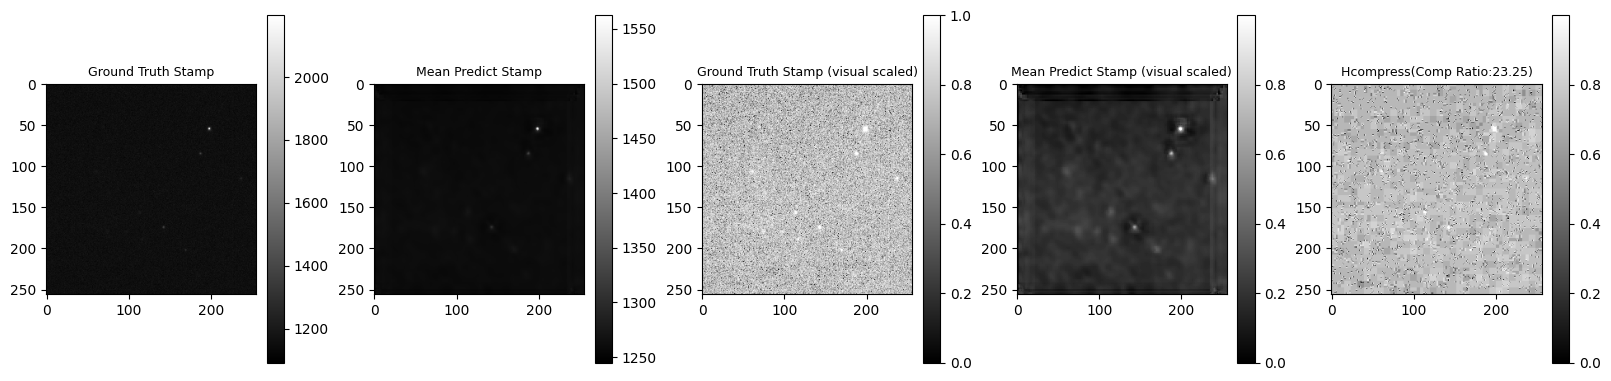

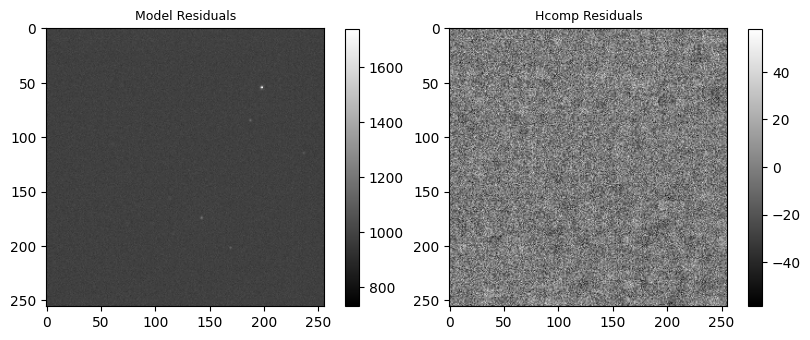

In [ ]:
# test and visualize construction
idx = np.random.randint(0, len(test_path_list))
file_path = test_path_list[idx]

image_data = np.load(file_path)
mask_data = np.load('/content/combined_masks/' + file_path[24:-4] + '_mask.npy')
mask_data = mask_data.reshape(256,256,1)

interval = MinMaxInterval()
vmin, vmax = interval.get_limits(image_data)
image_data_scaled = np.log10(image_data-vmin+1)
original_stamp = image_data

with tf.device(device_name = '/device:GPU:0'):
    mean_pred_img, var_pred_img = np.array(autoencoder_C.predict(image_data_scaled.reshape(1, size, size, 1)))
    mean_pred_img = mean_pred_img.reshape(shape)
    var_pred_img = var_pred_img.reshape(shape)


# mean (reconstructed) plots
fig, axs = plt.subplots(1, 5, figsize=(16, 10), gridspec_kw={'wspace': 0.0, 'hspace': 0.0},
                        constrained_layout=True)

im0 = axs[0].imshow(original_stamp.reshape(size,size), cmap='gray')
axs[0].set_title('Ground Truth Stamp', fontsize = 9)
fig.colorbar(im0, ax=axs[0], shrink=0.35)

im4 = axs[1].imshow(mean_pred_img+vmin-1, cmap='gray')
axs[1].set_title('Mean Predict Stamp' , fontsize=9)
fig.colorbar(im4, ax=axs[1], shrink=0.35)

im2 = axs[2].imshow(visual_transform_image(original_stamp).reshape(size,size), cmap='gray')
axs[2].set_title('Ground Truth Stamp (visual scaled)', fontsize = 9)
fig.colorbar(im2, ax=axs[2], shrink=0.35)

im3 = axs[3].imshow(visual_transform_image(mean_pred_img+vmin-1), cmap='gray')
axs[3].set_title('Mean Predict Stamp (visual scaled)' , fontsize=9)
fig.colorbar(im3, ax=axs[3], shrink=0.35)


# fpack compression

compression_type = 'HCOMPRESS_1'
image_data_32 = image_data.astype('float32')

hdu = fits.PrimaryHDU(image_data_32.reshape(256,256))
hdu.writeto('uncompressed_file.fits', overwrite = True)
compressed_hdu = fits.CompImageHDU(data = image_data_32.reshape(256,256), compression_type=compression_type, quantize_level = 2, hcomp_scale=16)
new_hdulist = fits.HDUList([fits.PrimaryHDU(), compressed_hdu])
new_hdulist.writeto('COMP_compressed_file.fits', overwrite = True)

file_path = 'uncompressed_file.fits'
file_size = os.path.getsize(file_path)
#print('uncompressed file size:', file_size, 'bytes')

file_path_comp = 'COMP_compressed_file.fits'
file_size_comp = os.path.getsize(file_path_comp)
#print('compressed file size:', file_size_comp, 'bytes')

hcomp_ratio = file_size/file_size_comp

print('Compression ratio:', hcomp_ratio)


with fits.open('/content/COMP_compressed_file.fits') as hdu:
  COMP_data = hdu[1].data

compressed_data = COMP_data


im5 = axs[4].imshow(visual_transform_image(compressed_data), cmap = 'gray')
axs[4].set_title(f'Hcompress(Comp Ratio:{hcomp_ratio})', fontsize = 9)
fig.colorbar(im5, ax=axs[4], shrink = 0.35)

# Residuals


fig, axs = plt.subplots(1, 2, figsize=(8, 8), gridspec_kw={'wspace': 0.0, 'hspace': 0.0},
                        constrained_layout=True)

model_residuals = original_stamp.reshape(256,256) - mean_pred_img.reshape(256,256)
hcomp_residuals = original_stamp.reshape(256,256) - compressed_data.reshape(256,256)

im0 = axs[0].imshow(model_residuals.reshape(size,size), cmap='gray')
axs[0].set_title('Model Residuals', fontsize = 9)
fig.colorbar(im0, ax=axs[0], shrink=0.35)

im4 = axs[1].imshow(hcomp_residuals, cmap='gray')
axs[1].set_title('Hcomp Residuals' , fontsize=9)
fig.colorbar(im4, ax=axs[1], shrink=0.35)






In [ ]:
# save weights
autoencoder_C.save_weights('/content/drive/MyDrive/model_weights/256_weights_ffl.h5')

In [ ]:
# reload weights
autoencoder_C.load_weights('/content/drive/MyDrive/model_weights/256_weights_ffl.h5')